In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

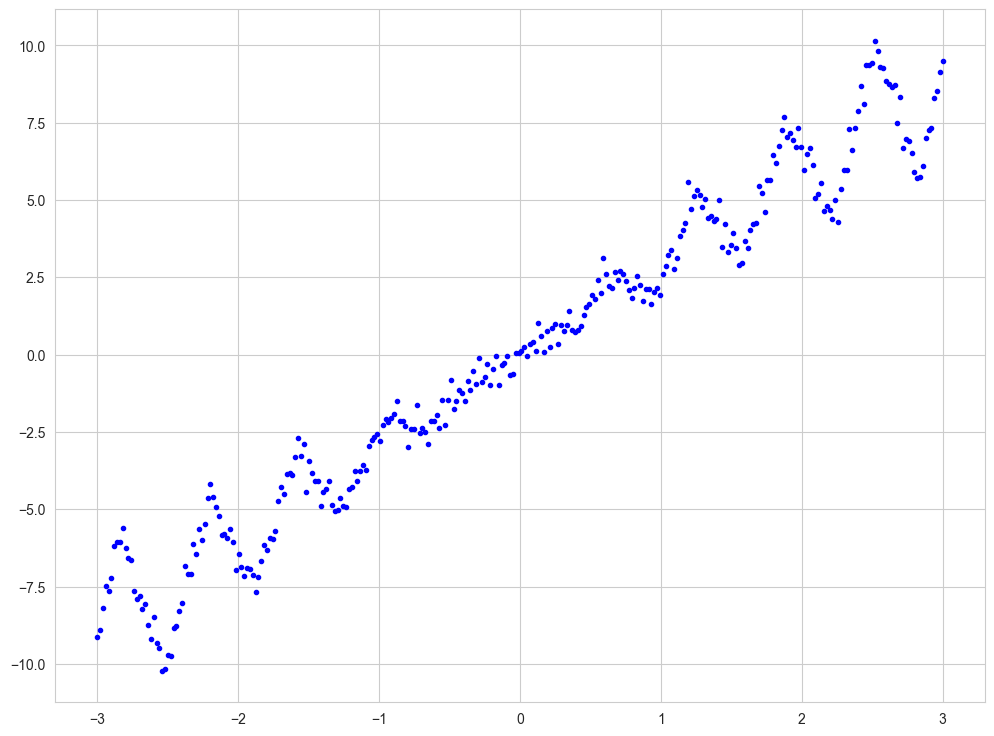

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

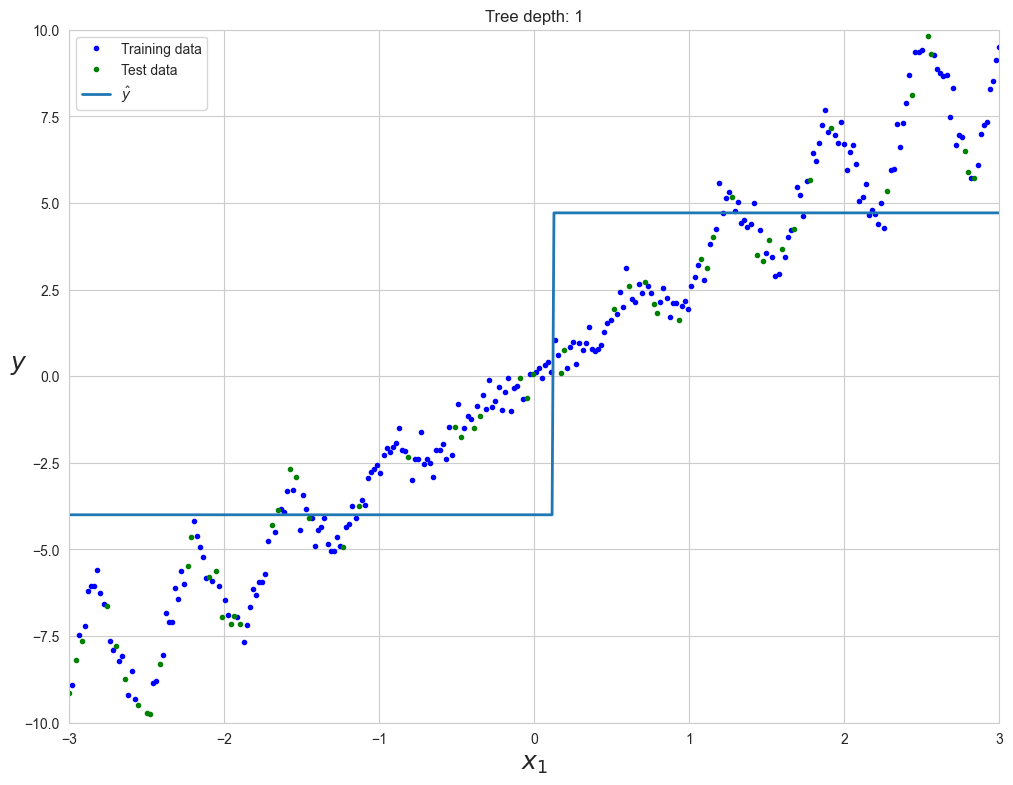

In [5]:
def plot_tree_regression_predictions(max_depth):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
    tree_reg = DecisionTreeRegressor(max_depth=max_depth, random_state=SEED)
    tree_reg.fit(X_train, y_train)
    plt.figure(figsize=(12, 9))
    plt.plot(X_train, y_train, "b.", label="Training data")
    plt.plot(X_test, y_test, "g.", label="Test data")
    plot_regression_predictions(tree_reg, X, y)
    plt.legend()
    title = f"Tree depth: {max_depth}"
    plt.title(title)
    plt.show()

plot_tree_regression_predictions(max_depth=1)

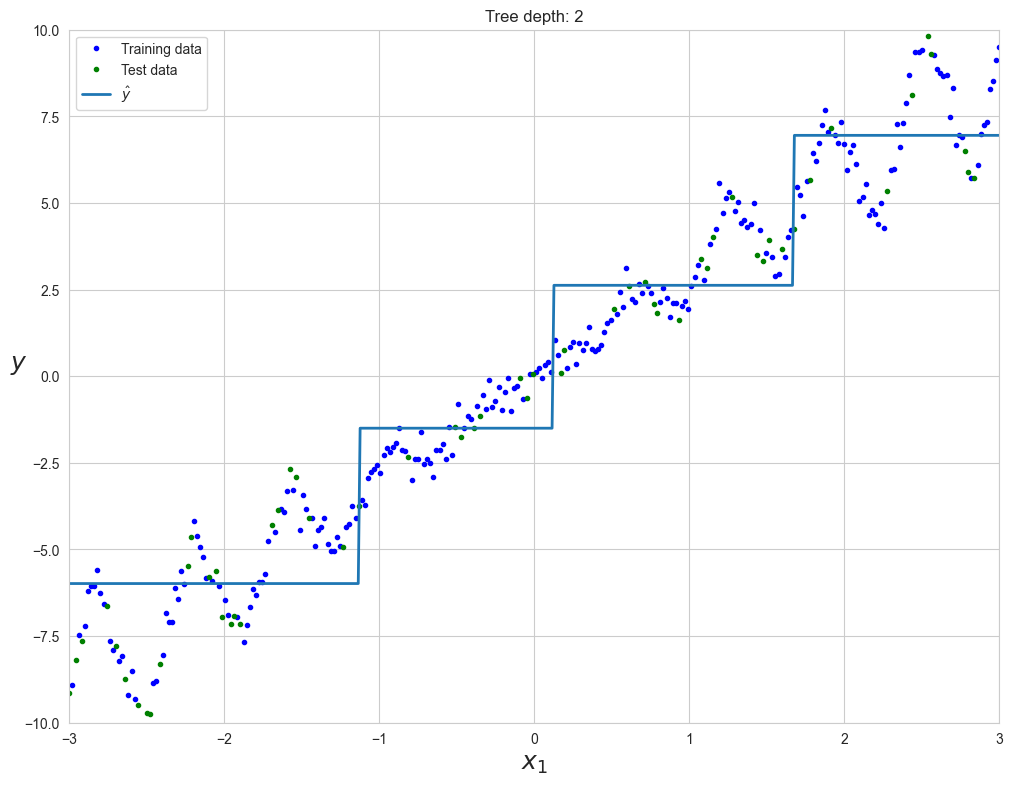

In [6]:
plot_tree_regression_predictions(max_depth=2)

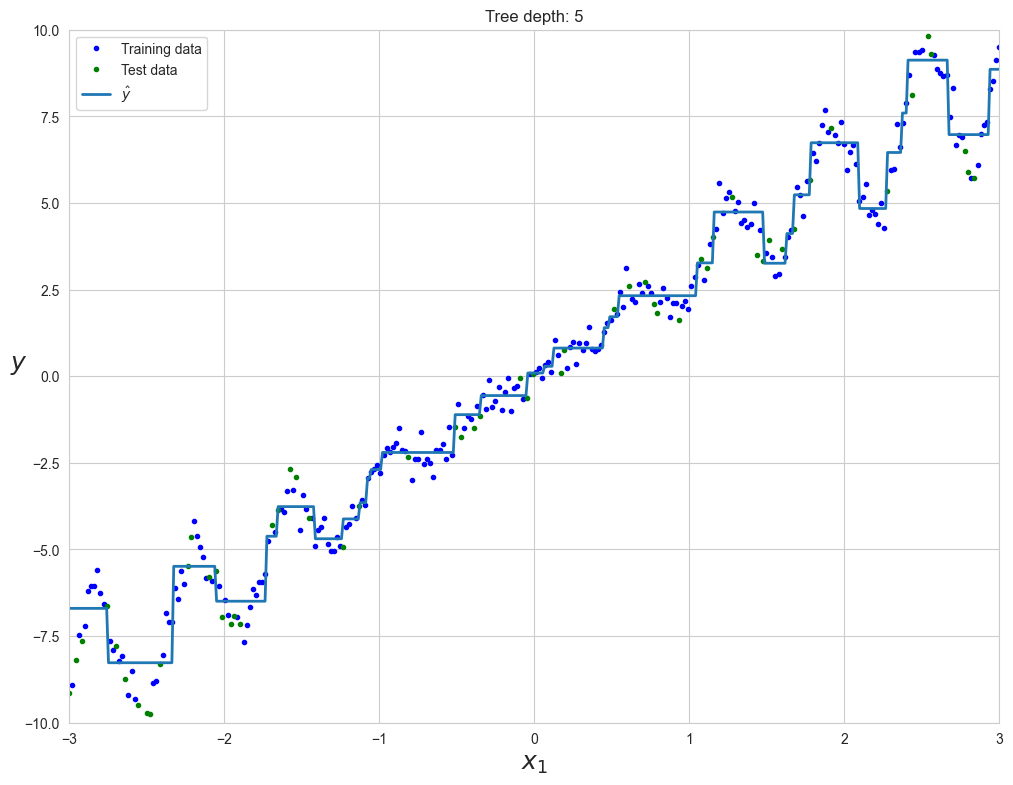

In [7]:
plot_tree_regression_predictions(max_depth=5)

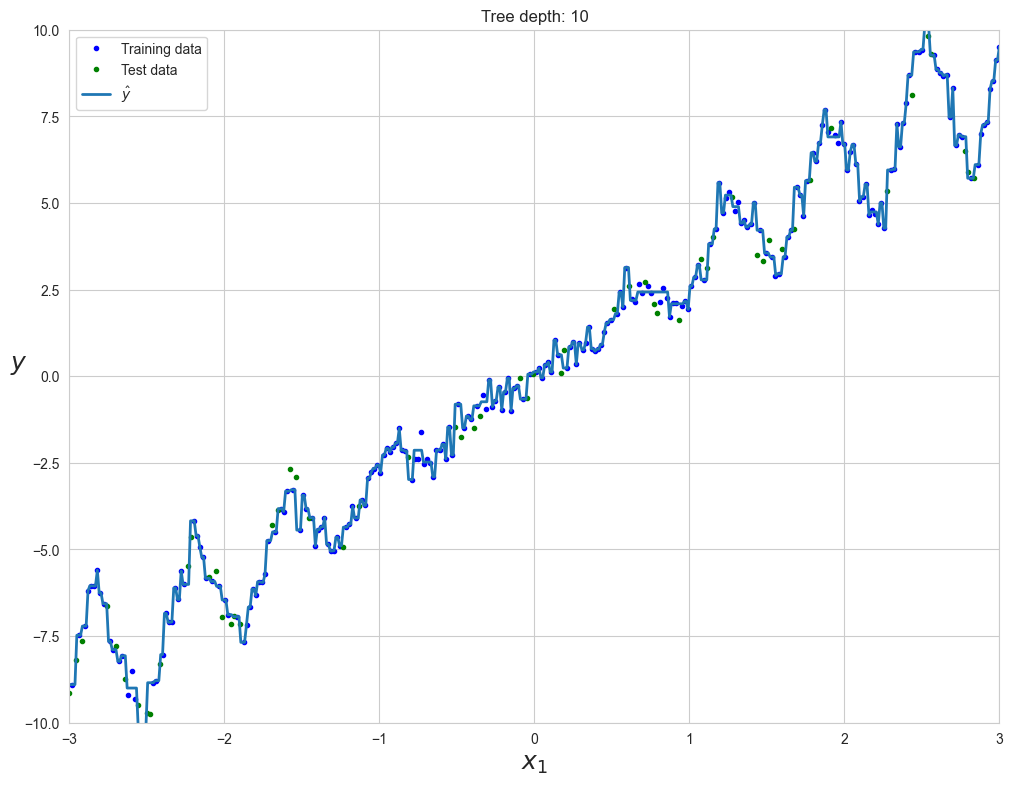

In [8]:
plot_tree_regression_predictions(max_depth=10)

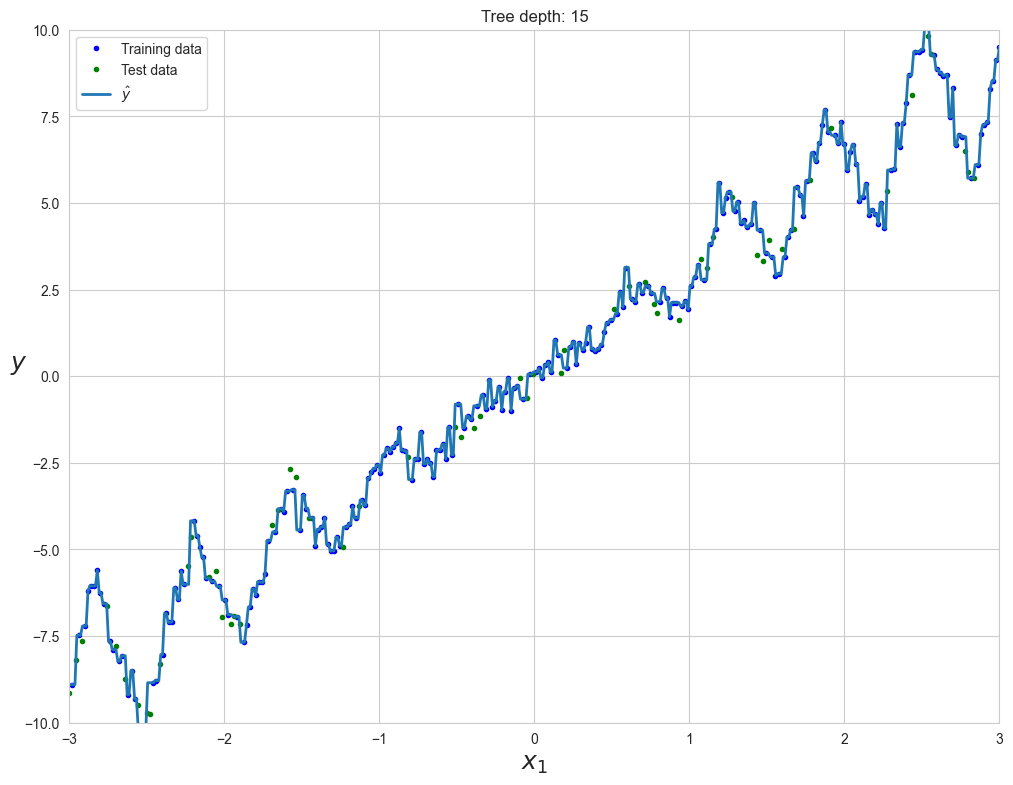

In [9]:
plot_tree_regression_predictions(max_depth=15)

Как видно, дерево глубины 5 неплохо улавливает общий тренд, а деревья глубины 10 и более, переобучаются под выборку

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

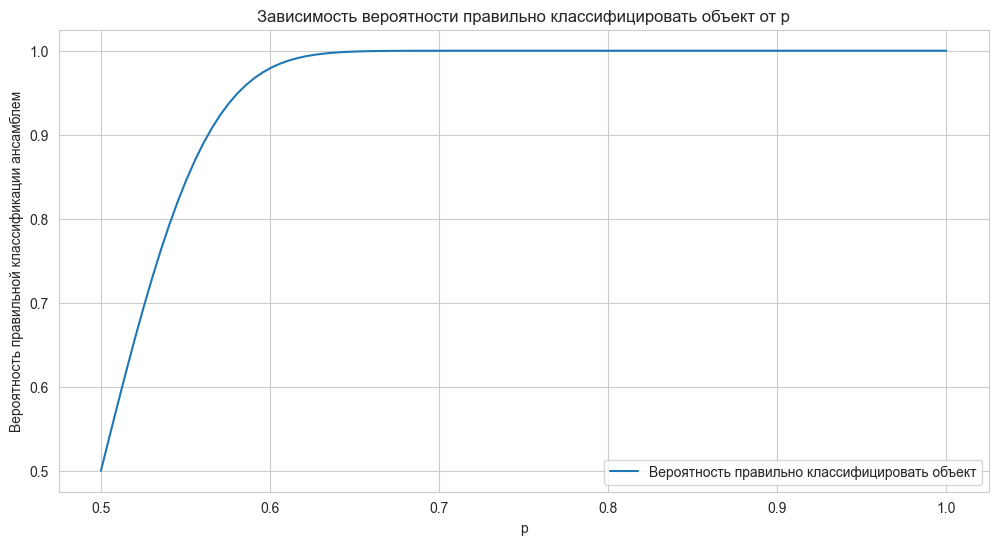

In [10]:
from scipy.special import comb

def majority_vote_probability(p):
    majority_count = 51 
    total_classifiers = 101
    probabilities = [
        comb(total_classifiers, i) * (p ** i) * ((1 - p) ** (total_classifiers - i))
        for i in range(majority_count, total_classifiers + 1)
    ]
    return sum(probabilities)
p_values = np.linspace(0.5, 1.0, 100)
probabilities = np.array([majority_vote_probability(p) for p in p_values])

plt.figure(figsize=(12, 6))
plt.plot(p_values, probabilities, label='Вероятность правильно классифицировать объект')
plt.xlabel('p')
plt.ylabel('Вероятность правильной классификации ансамблем')
plt.title('Зависимость вероятности правильно классифицировать объект от p')
plt.legend()
plt.grid(True)
plt.show()

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

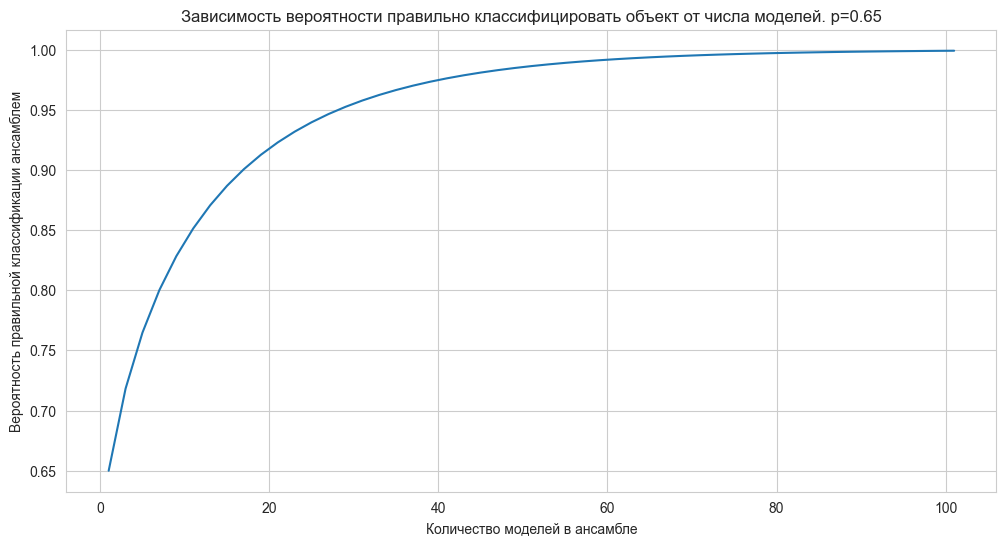

In [12]:
def ensemble_majority_vote_probability(num_classifiers, p=0.65):
    majority_count = math.ceil(num_classifiers / 2)
    probabilities = [
        comb(num_classifiers, i) * (p ** i) * ((1 - p) ** (num_classifiers - i))
        for i in range(majority_count, num_classifiers + 1)
    ]
    return sum(probabilities)
num_classifiers_range = list(range(1, 102, 2))
ensemble_probabilities = [ensemble_majority_vote_probability(n) for n in num_classifiers_range]

plt.figure(figsize=(12, 6))
plt.plot(num_classifiers_range, ensemble_probabilities)
plt.xlabel('Количество моделей в ансамбле')
plt.ylabel('Вероятность правильной классификации ансамблем')
plt.title('Зависимость вероятности правильно классифицировать объект от числа моделей. p=0.65')
plt.grid(True)
plt.show()

Опишите ваши наблюдения:

* В первом случае при p 0.6 и выше -- вероятность правильно проклассифицировать объект ансамблем уже очень близка к единице, что логично
* Во втором случае вероятность растет не так быстро, но 50 моделей и более хватает для 95%+ уверенности в верности предсказания

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [14]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.base import BaseEstimator

class RandomForestClassifierCustom(BaseEstimator):
    def __init__(self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        n_features = X.shape[1]
        self.classes_ = np.unique(y)
        self.trees = []
        self.feat_ids_by_tree = [] 
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
            if self.max_features is None:
                self.max_features = n_features
            feat_ids = np.random.choice(n_features, self.max_features, replace=False)
            self.feat_ids_by_tree.append(feat_ids)
            bootstrap_indices = np.random.choice(np.arange(X.shape[0]), size=X.shape[0], replace=True)
            X_bootstrap = X[bootstrap_indices][:, feat_ids]
            y_bootstrap = y[bootstrap_indices]
            tree = DecisionTreeClassifier(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X_bootstrap, y_bootstrap)
            self.trees.append(tree)
        
        return self

    def predict_proba(self, X):
        probas = np.zeros((X.shape[0], len(self.classes_)), dtype=np.float64)
        for tree, feat_ids in zip(self.trees, self.feat_ids_by_tree):
            tree_probas = tree.predict_proba(X[:, feat_ids])
            for i, cl in enumerate(tree.classes_):
                cl_idx = np.where(self.classes_ == cl)[0][0]
                probas[:, cl_idx] += tree_probas[:, i]
        probas /= self.n_estimators
        return probas
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        return self.classes_[predictions]

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [15]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

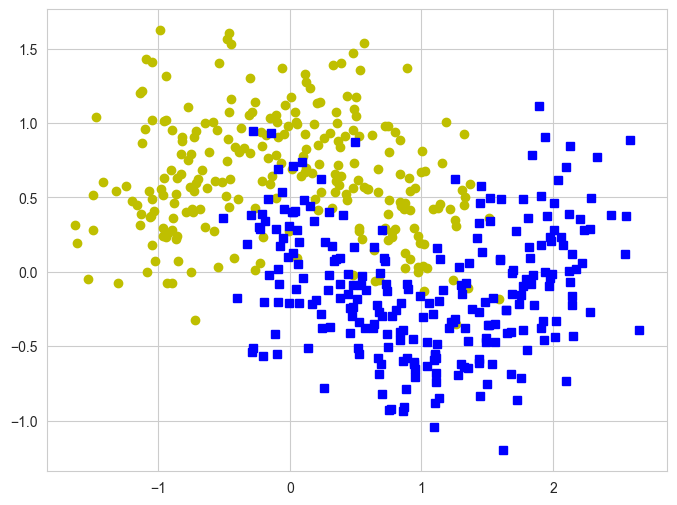

In [16]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

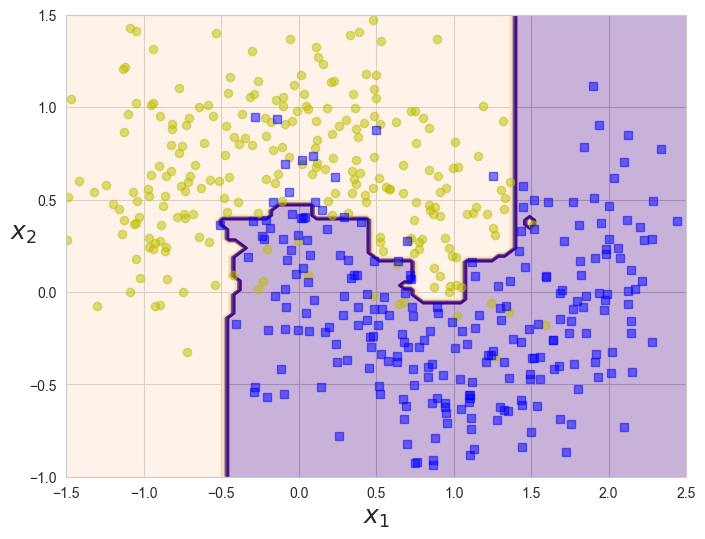

In [17]:
custom_forest_clf = RandomForestClassifierCustom(n_estimators=100, max_depth=6, max_features=2, random_state=SEED)
custom_forest_clf.fit(X, y)
plt.figure(figsize=(8, 6))
plot_decision_boundary(custom_forest_clf, X, y)
plt.show()

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

Подкручивать пришлось недолго, результат можно увидеть выше -- как мне кажется, это наиболее подходящая с точки зрения bias-variance trade-off граница

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [18]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [19]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

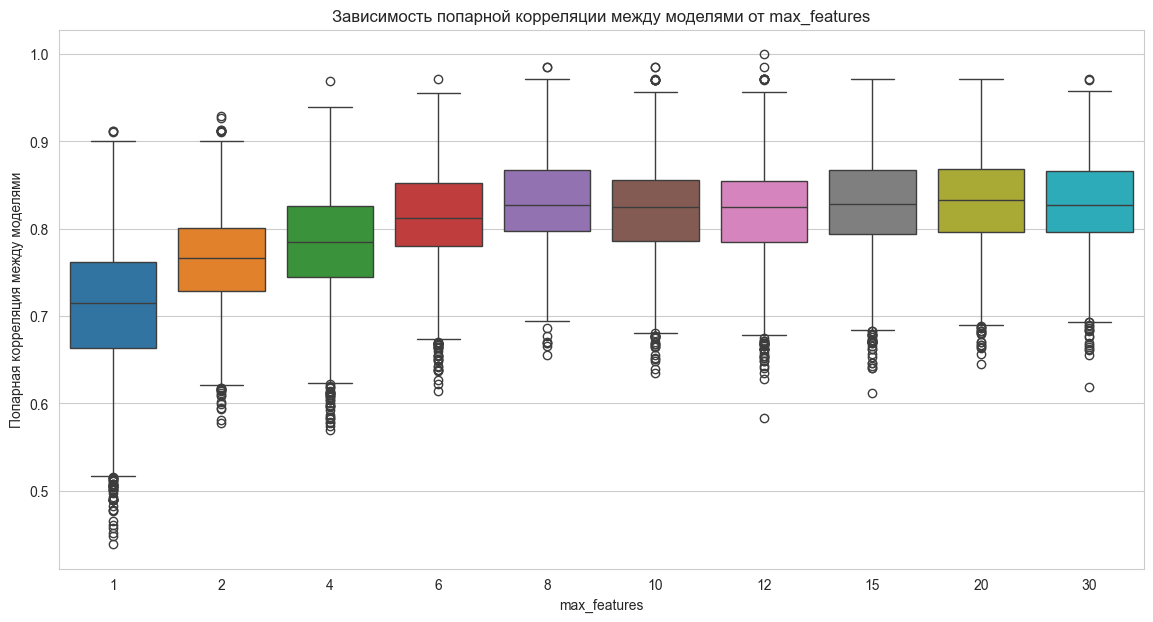

In [20]:
from itertools import combinations
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

max_features_opts = [1, 2, 4, 6, 8, 10, 12, 15, 20, X.shape[1]]
correlation_results = []

for max_features in max_features_opts:
    clf = RandomForestClassifier(n_estimators=100, max_features=max_features, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)
    corrs = base_model_pair_correlation(clf, X_test)
    correlation_results.append(corrs)

plt.figure(figsize=(14, 7))
sns.boxplot(data=correlation_results)
plt.xlabel('max_features')
plt.ylabel('Попарная корреляция между моделями')
plt.title('Зависимость попарной корреляции между моделями от max_features')
plt.xticks(ticks=range(len(max_features_opts)), labels=max_features_opts)
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

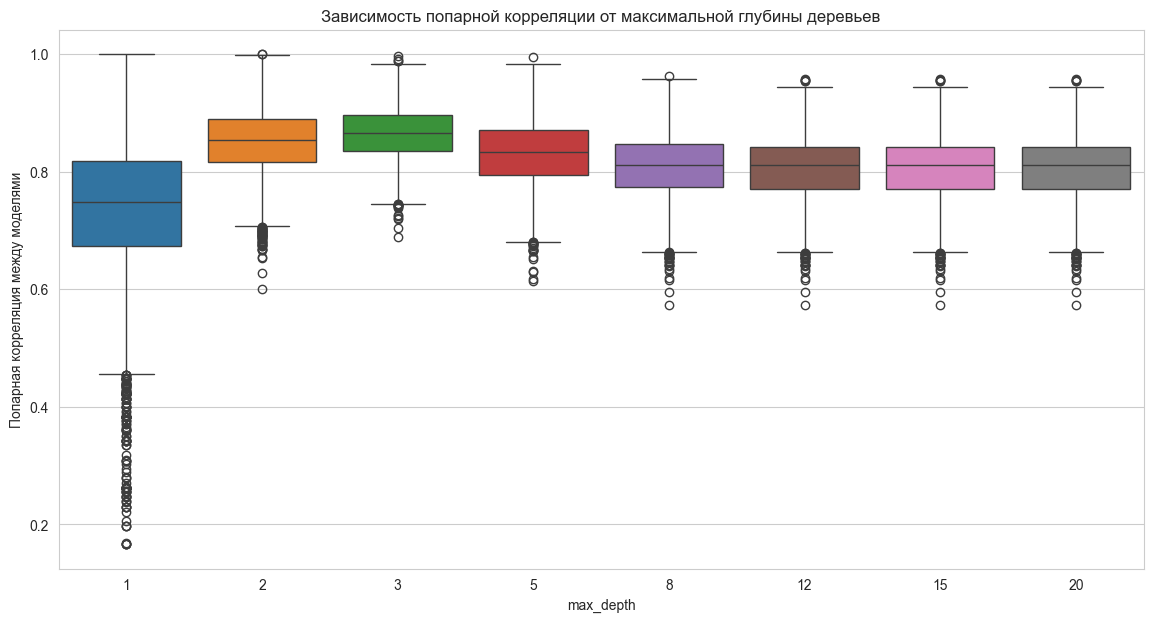

In [21]:

max_depth_opts = [1, 2, 3, 5, 8, 12, 15, 20]
correlation_results_depth = []

for max_depth in max_depth_opts:
    clf = RandomForestClassifier(n_estimators=100, max_depth=max_depth, max_features='sqrt', random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)
    corrs = base_model_pair_correlation(clf, X_test)
    correlation_results_depth.append(corrs)

plt.figure(figsize=(14, 7))
sns.boxplot(data=correlation_results_depth)
plt.xlabel('max_depth')
plt.ylabel('Попарная корреляция между моделями')
plt.title('Зависимость попарной корреляции от максимальной глубины деревьев')
plt.xticks(ticks=range(len(max_depth_opts)), labels=max_depth_opts)
plt.show()

Опишите ваши наблюдения:

* В первом случае корреляция постепенно растет, затем выходит на плато -- т. к. все больше общих признаков у базовых моделей в обучении

* Во втором случае корреляции сначала растет, затем немного снижается, и только потом выходит на плато -- из-за большой глубины деревьев, они переобучаются под свое подпространство и чуть меньше начинают коррелировать

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [25]:
import pandas as pd
!gdown 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("heart.csv")

In [26]:
heart_dataset

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [27]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [52]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED, verbose=-1)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED, verbose=-1)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [41]:
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')


for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")
    


DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.8281746031746032
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.8134522115571786
LGBMClassifier: 0.817010631644778
XGBRFClassifier: 0.8462669018224572
LGBMClassifier: 0.8132478632478634
LogisticRegression: 0.8500073681108163
GaussianNB: 0.8140676625250128
VotingClassifier: 0.8445754787218203
VotingClassifier: 0.8503633581946834


Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [42]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [43]:
voting_classifier = VotingClassifier(estimators=base_models, voting='soft')
voting_classifier.fit(X_train, y_train)
correlations = base_model_pair_correlation_for_voting_clf(voting_classifier, X_test)


for est1, est2, corr in correlations:
    print(f"Корреляция между {est1.__class__.__name__} и {est2.__class__.__name__}: {corr:.3f}")

Корреляция между DecisionTreeClassifier и RandomForestClassifier: 0.813
Корреляция между DecisionTreeClassifier и ExtraTreesClassifier: 0.775
Корреляция между DecisionTreeClassifier и KNeighborsClassifier: 0.313
Корреляция между DecisionTreeClassifier и SVC: 0.715
Корреляция между DecisionTreeClassifier и SVC: 0.282
Корреляция между DecisionTreeClassifier и CatBoostClassifier: 0.788
Корреляция между DecisionTreeClassifier и LGBMClassifier: 0.828
Корреляция между DecisionTreeClassifier и LGBMClassifier: 0.861
Корреляция между DecisionTreeClassifier и XGBClassifier: 0.809
Корреляция между DecisionTreeClassifier и XGBRFClassifier: 0.876
Корреляция между DecisionTreeClassifier и LogisticRegression: 0.740
Корреляция между DecisionTreeClassifier и GaussianNB: 0.683
Корреляция между RandomForestClassifier и ExtraTreesClassifier: 0.922
Корреляция между RandomForestClassifier и KNeighborsClassifier: 0.392
Корреляция между RandomForestClassifier и SVC: 0.826
Корреляция между RandomForestClassifi

Наилучший вариант у меня был voting_soft with models [0, 1, 2, 6, 7, 10]: 0.8624

Если на тесте, то ансамбль из всех моделей его набирает

In [58]:
from sklearn.metrics import f1_score

voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
voting_hard.fit(X_train, y_train)
predictions_hard = voting_hard.predict(X_test)
f1_hard = f1_score(y_test, predictions_hard)
print(f"voting_hard on test: {f1_hard:.4f}")
voting_soft.fit(X_train, y_train)
predictions_soft = voting_soft.predict(X_test)
f1_soft = f1_score(y_test, predictions_soft)
print(f"voting_soft on test: {f1_soft:.4f}")

voting_hard on test: 0.8738
voting_soft on test: 0.8738


### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [83]:
df = pd.read_csv("../data/churn.csv")
df.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [84]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

binary_cols = ["Int'l Plan", 'VMail Plan']
for col in binary_cols:
    df[col] = df[col].apply(lambda x: 1 if x.strip().lower() == 'yes' else 0)
df['Churn?'] = df['Churn?'].apply(lambda x: 1 if x.strip().lower() == 'true.' else 0)
df.drop(['State','Area Code', 'Phone'], axis=1, inplace=True)
X = df.drop('Churn?', axis=1)
y = df['Churn?']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [86]:
from xgboost import XGBRFClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, accuracy_score
xgb_rf_model = XGBRFClassifier(n_estimators=100, random_state=42)
xgb_rf_model.fit(X_train, y_train)
xgb_rf_predictions = xgb_rf_model.predict(X_test)
xgb_rf_f1 = f1_score(y_test, xgb_rf_predictions)
print(f'F1 Score for XGBRF: {xgb_rf_f1}')
catboost_model = CatBoostClassifier(iterations=100, verbose=0, random_seed=42)
catboost_model.fit(X_train, y_train)
cat_predictions = catboost_model.predict(X_test)
cat_f1 = f1_score(y_test, cat_predictions)
print(f'F1 Score for CatBoost: {cat_f1}')

F1 Score for XGBRF: 0.8105263157894737
F1 Score for CatBoost: 0.8068181818181818


### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:


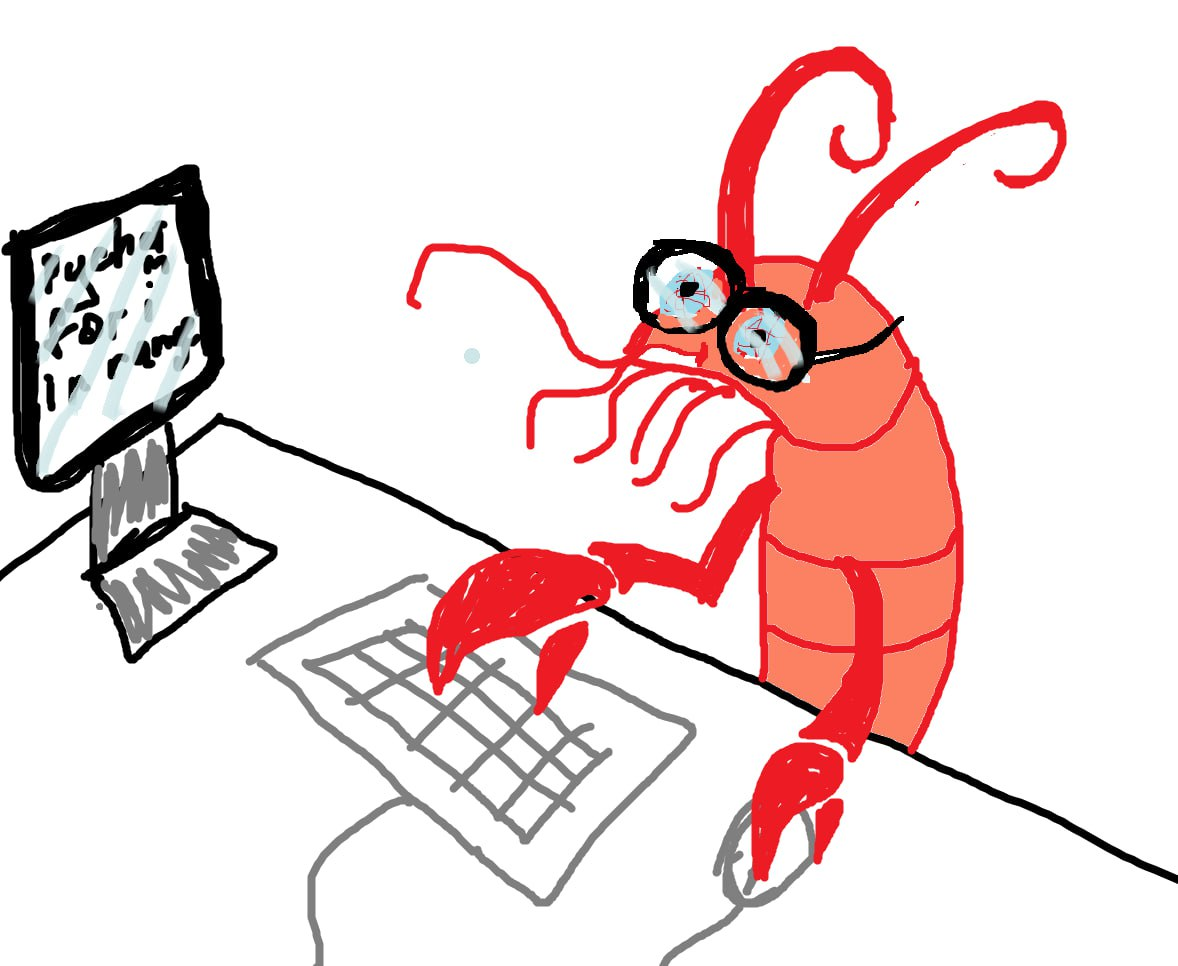

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**